# Trajectory Interpolation Example

Example that uses a simple constant-velocity prior over a trajectory that has some fake GPS-like measurements and with interpolation.


In [1]:
import numpy as np
import numpy.linalg as npla
np.set_printoptions(6, suppress=True)

import matplotlib.pyplot as plt
%matplotlib inline

from pylgmath import so3op, se3op, Transformation
from pysteam.evaluable.se3 import SE3StateVar
from pysteam.evaluable.vspace import VSpaceStateVar
from pysteam.evaluable.p2p import P2PErrorEvaluator
from pysteam.trajectory import Time, TrajectoryInterface
from pysteam.problem import OptimizationProblem, StaticNoiseModel, L2LossFunc, WeightedLeastSquareCostTerm
from pysteam.solver import GaussNewtonSolver

Options:


In [2]:
num_states = 100  # total number of states
dt = 1  # time step

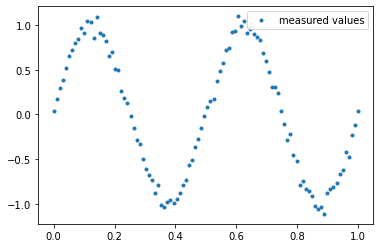

In [3]:
# Create some fake measurements (can consider as gps measurements lat-long-alt being converted to xyz)
fake_meas = np.empty((num_states, 4, 1))
fake_meas[:, 0, 0] = np.linspace(0, 1, num_states)
fake_meas[:, 1,
          0] = np.sin(fake_meas[:, 0, 0] * 4 * np.pi) + np.random.normal(scale=0.05, size=fake_meas[:, 1, 0].shape)
fake_meas[:, 2, 0] = 0.0  # z to zero so the problem is 2D
fake_meas[:, 3, 0] = 1.0  # homogeneous coordinate

plt.plot(fake_meas[:, 0], fake_meas[:, 1], '.', label='measured values')
plt.legend()

Create states and wrap them with pysteam variables:


In [4]:
# states with initial conditions and associated timestamps
# T_ba = T_k0 where 0 can be some global frame (e.g. UTM) and k is the vehicle/robot frame at time k
states = [
    (dt * i, Transformation(C_ba=np.eye(3), r_ba_in_a=fake_meas[i, :3]), np.zeros((6, 1))) for i in range(num_states)
]

# wrap states with corresponding steam state variables (no copying!)
state_vars = [(t, SE3StateVar(T_vi), VSpaceStateVar(w_iv_inv)) for t, T_vi, w_iv_inv in states]

Construct a trajectory with a constant velocity prior for smoothing where knots are states at measurement times:


In [5]:
Qc_inv = np.diag(1 / np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0]))  # smoothing factor diagonal
traj = TrajectoryInterface(Qc_inv=Qc_inv)
for t, T_vi, w_iv_inv in state_vars:
  traj.add_knot(time=Time(t), T_k0=T_vi, w_0k_ink=w_iv_inv)

Construct measurement cost terms:


In [6]:
cost_terms = []
# use a shared L2 loss function and noise model for all cost terms
loss_func = L2LossFunc()
noise_model = StaticNoiseModel(np.eye(3), "information")
for i in range(num_states):
  error_func = P2PErrorEvaluator(T_rq=state_vars[i][1], reference=np.array([[0, 0, 0, 1]]).T, query=fake_meas[i])
  cost_terms.append(WeightedLeastSquareCostTerm(error_func, noise_model, loss_func))

Construct the optimization problem and solve:


In [7]:
opt_prob = OptimizationProblem()
opt_prob.add_state_var(*[v for state_var in state_vars for v in state_var[1:]])
opt_prob.add_cost_term(*traj.get_prior_cost_terms())
opt_prob.add_cost_term(*cost_terms)

solver = GaussNewtonSolver(opt_prob, verbose=True)
solver.optimize()

Begin Optimization
------------------
Number of States:  200
Number of Cost Terms:  199
Initial Cost:  8.60895854257741
Iteration:    1  -  Cost:     0.1037
Iteration:    2  -  Cost:     0.1037
Termination Cause:  CONVERGED ABSOLUTE CHANGE
Total Optimization Time: 0.7371 seconds


Print out results:


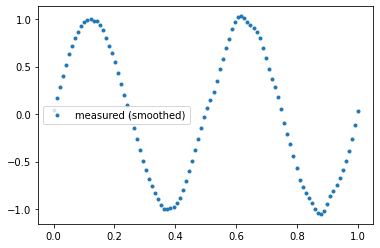

In [8]:
T_0k = np.array([npla.inv(x.matrix()) for _, x, _ in states])

plt.plot(T_0k[:, 0, 3], T_0k[:, 1, 3], '.', label="measured (smoothed)")
plt.legend()

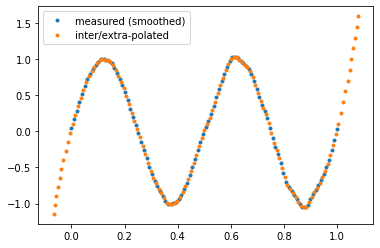

In [9]:
T_k0_interp = [
    traj.get_pose_interpolator(Time(dt * i + dt / 2)).evaluate().matrix() for i in range(-10, num_states + 10)
]

T_0k_interp = np.array([npla.inv(x) for x in T_k0_interp])
plt.plot(T_0k[:, 0, 3], T_0k[:, 1, 3], '.', label="measured (smoothed)")
plt.plot(T_0k_interp[:, 0, 3], T_0k_interp[:, 1, 3], '.', label="inter/extra-polated")
plt.legend()